In [1]:
# %matplotlib ipympl
# %matplotlib notebook

# GRP Hopper Simplified

https://ieeexplore.ieee.org/document/7989248

## Simplified Version

In [2]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywumacmini/Desktop/hopper_sim


In [3]:
import yaml

with open("cfg/GRP_hopper_simplified.yaml", "r") as f:
    cfg = yaml.safe_load(f)

hopper_cfg = cfg["simplified_GRP_hopper"]
mb = hopper_cfg["mb"]
mf = hopper_cfg["mf"]
l0 = hopper_cfg["l0"]
g = hopper_cfg["g"]

from models.GRP_hopper_simplified import simplified_GRP_hopper
hopper = simplified_GRP_hopper(mb,mf,l0,g)

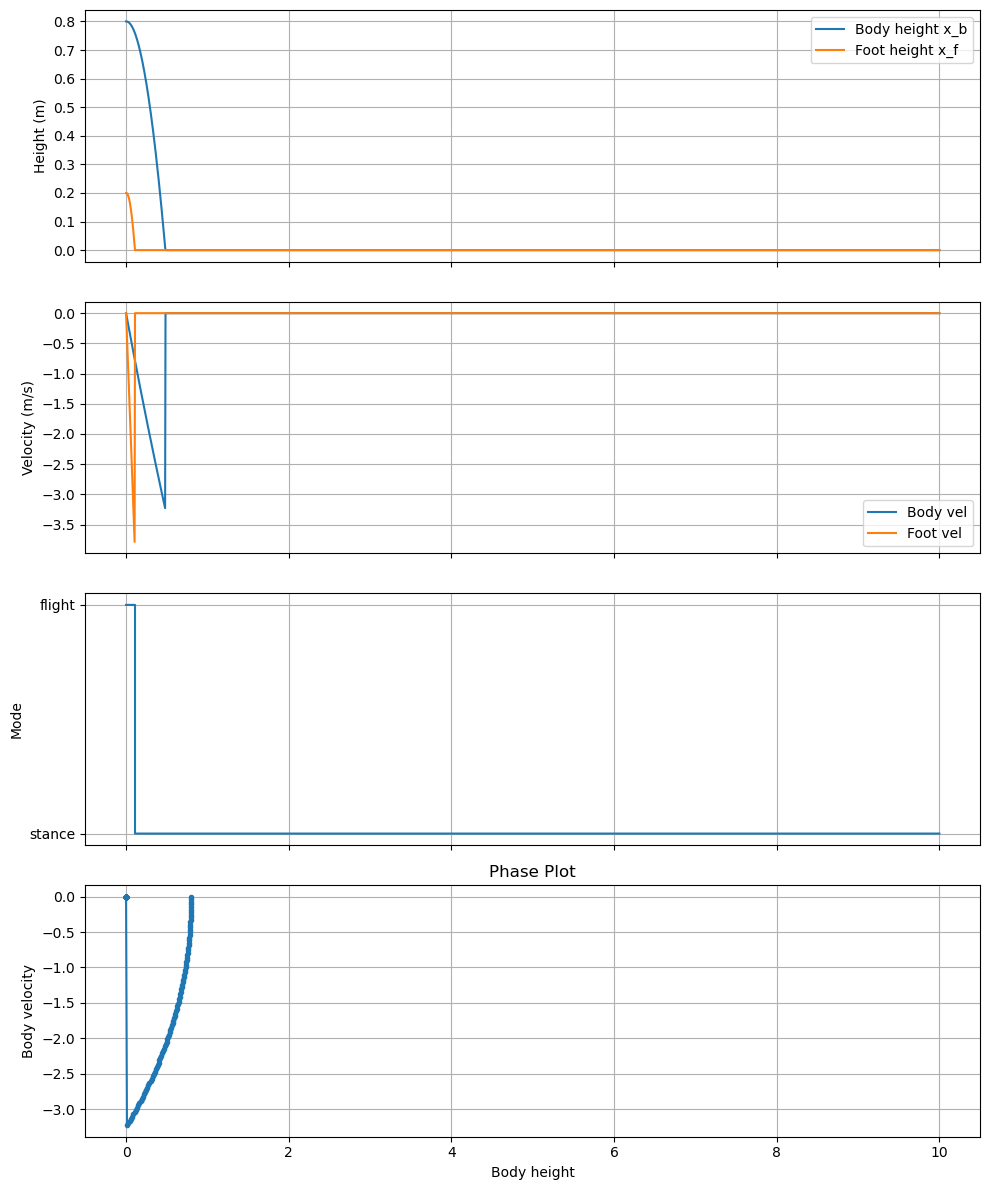

In [8]:
import numpy as np 
import matplotlib.pyplot as plt

# ============================================================
# Simulation Setup (Passive)
# ============================================================
dt = hopper_cfg["controller"]["NLP"]["dt_control"]

sim_T = 10.0            # total simulation time (seconds)
sim_N = int(sim_T / dt)

x0 = np.array(hopper_cfg["x0"][0], dtype=float)

# Initialize mode
mode = "flight" if x0[2] > 0 else "stance"

x = x0.copy()
u = 5*np.sin(np.arange(sim_N) * dt)+5   # passive system

# Data history
X_hist = [x.copy()]
mode_hist = [mode]

# ============================================================
# Simulation Loop
# ============================================================
for k in range(sim_N):

    if mode == "flight":
        x_dot, F_sub = hopper.flight_state(x, u[k])
        x_next = x + x_dot * dt

        if hopper.detect_touchdown(x_next):
            x_next = hopper.apply_touchdown_impulse(x_next)
            mode = "stance"

    else:   # stance
        x_dot, F_sub = hopper.stance_state(x, u[k])
        x_next = x + x_dot * dt

        if x_next[0] < 0:
            x_next[0] = 0.0
            if x_next[1] < 0:
                x_next[1] = 0.0

        if hopper.detect_liftoff(x_next, F_sub):
            x_next = hopper.apply_liftoff_impulse(x_next)
            mode = "flight"

    x = x_next
    X_hist.append(x.copy())
    mode_hist.append(mode)

# ============================================================
# Convert to arrays
# ============================================================
X_hist = np.array(X_hist)
mode_hist = np.array(mode_hist)
t = np.arange(len(X_hist)) * dt

# ============================================================
# Plotting
# ============================================================
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 1. Heights
axs[0].plot(t, X_hist[:,0], label="Body height x_b")
axs[0].plot(t, X_hist[:,2], label="Foot height x_f")
axs[0].set_ylabel("Height (m)")
axs[0].grid(True)
axs[0].legend()

# 2. Velocities
axs[1].plot(t, X_hist[:,1], label="Body vel")
axs[1].plot(t, X_hist[:,3], label="Foot vel")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].grid(True)
axs[1].legend()

# 3. Mode (flight = 1, stance = 0)
mode_num = (mode_hist == "flight").astype(int)
axs[2].plot(t, mode_num, drawstyle="steps-post")
axs[2].set_ylabel("Mode")
axs[2].set_yticks([0,1])
axs[2].set_yticklabels(["stance","flight"])
axs[2].grid(True)

# 4. Phase plot
axs[3].plot(X_hist[:,0], X_hist[:,1], '.-')
axs[3].set_xlabel("Body height")
axs[3].set_ylabel("Body velocity")
axs[3].set_title("Phase Plot")
axs[3].grid(True)

plt.tight_layout()
plt.show()


### NLP Controller for States Machine

In [5]:
import numpy as np

NLP_cfg = hopper_cfg["controller"]["NLP"]
H = NLP_cfg["H"]
dt = NLP_cfg["dt_control"]
x0 = np.array(hopper_cfg["x0"][0])  # Extract first element and convert to 1D numpy array
if x0[2] > 0:
    state_current = "flight"
else:
    state_current = "stance"
mode_seq = [state_current] * H  # Create list of mode strings
u_min = NLP_cfg["u_min"]
u_max = NLP_cfg["u_max"]
R_u = NLP_cfg["R_u"]
Q_terminal = NLP_cfg["Q_terminal"]
body_ref = NLP_cfg["body_ref"] 

NLPController = simplified_GRP_hopper.NLPController(hopper, H, dt, x0, mode_seq, u_min, u_max, R_u, Q_terminal, body_ref)

### Passive System